In [1]:
!pip uninstall -y deepxde && rm -rf deepxde; git clone https://github.com/ewang729/deepxde.git ; cd deepxde && git config --global user.email "a@a.com" ; git config --global user.name "a"; git checkout loss-scaling ;ls;pip install ./
!pip install matplotlib

Cloning into 'deepxde'...
remote: Enumerating objects: 7485, done.
remote: Counting objects: 100% (928/928), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 7485 (delta 854), reused 826 (delta 817), pack-reused 6557
Receiving objects: 100% (7485/7485), 26.76 MiB | 15.57 MiB/s, done.
Resolving deltas: 100% (5394/5394), done.
error: pathspec 'loss-scaling' did not match any file(s) known to git
CITATION.cff  deepxde  docker  docs  examples  LICENSE	pyproject.toml	README.md  requirements.txt
Processing /content/deepxde
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 2.5 MB/s eta 0:00:00
  Created wheel for DeepXDE: filename=DeepXDE-0.1.dev1071+gc98008f-py3-none-any.whl size=157879 sha256=49830911fb41b13f181b764d6ab09651dcb8fd77ef135e6409fc3a0d5f56b01a
  Stored in directory: /tmp

In [2]:
%env DDE_BACKEND=pytorch
import deepxde as dde
import numpy as np
import torch
import matplotlib.pyplot as plt


def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return (
         dy_t
         - dy_xx
         + torch.exp(-x[:, 1:])
         * (torch.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * torch.sin(np.pi * x[:, 0:1]))
    )


def func(x):
    return np.sin(np.pi * x[:, 0:1]) * np.exp(-x[:, 1:])

prev_grad = []
prev_weight = []
cosines = []
gradnorm = []
graddiff = []
wnorm = []
L = [0]
loss_mixed = []
loss_32 = []
scaler = torch.cuda.amp.GradScaler(enabled=True)

def get_grad(model):
    gradient = np.array([])
    for layer in model.net.linears:
        gradient = np.concatenate([gradient, layer.weight.grad.flatten().cpu().numpy()])
    return gradient

def get_weight(model):
    weights = np.array([])
    for layer in model.net.linears:
        weights = np.concatenate([weights, layer.weight.flatten().detach().cpu().numpy()])
    return weights

# calculation of both float32 and mixed gradients
def train_step_slow(model, inputs, targets):
    global prev_grad
    global prev_weight

    losses = model.outputs_losses_train(inputs, targets)[1]
    total_loss = torch.sum(losses)
    total_loss.backward()
    g2 = get_grad(model)
    model.opt.zero_grad()

    with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=True):
        losses = model.outputs_losses_train(inputs, targets)[1]
        total_loss = torch.sum(losses)
    scaler.scale(total_loss).backward()
    scaler.unscale_(model.opt)
    g1 = get_grad(model)
    scaler.step(model.opt)
    scaler.update()
    model.opt.zero_grad()

    cosines.append(np.dot(g1, g2)/(np.linalg.norm(g1)*np.linalg.norm(g2)))
    gradnorm.append(np.linalg.norm(g2))
    w = get_weight(model)
    wnorm.append(np.linalg.norm(w))
    graddiff.append(np.linalg.norm(g1 - g2))
    if(model.train_state.step != 0):
        L.append(np.linalg.norm(prev_grad - g2)/np.linalg.norm(prev_weight - w))
    prev_grad = g2
    prev_weight = w

# calculation of only float32 gradient
def train_step_fast(model, inputs, targets):
    losses = model.outputs_losses_train(inputs, targets)[1]
    total_loss = torch.sum(losses)
    total_loss.backward()
    model.opt.step()
    model.opt.zero_grad()

def train(model, iterations, display_every, train_step, loss):
    for i in range(iterations):
        model.train_state.set_data_train(
            *model.data.train_next_batch(model.batch_size)
        )
        train_step(
            model,
            model.train_state.X_train,
            model.train_state.y_train,
        )
        model.train_state.epoch += 1
        model.train_state.step += 1
        if model.train_state.step % display_every == 0 or i + 1 == iterations:
            print(model.train_state.step)

        X_test, y_test, _ = model.data.test()
        y_pred = model.predict(X_test)
        l2r = np.linalg.norm(y_pred - y_test) / np.linalg.norm(y_test)
        loss.append(l2r)

def test(amp, dde_precision, seed, size = 32, iter = 3500):
    dde.config.set_default_float(dde_precision)
    dde.config.set_random_seed(seed)
    geom = dde.geometry.Interval(-1, 1)
    timedomain = dde.geometry.TimeDomain(0, 1)
    geomtime = dde.geometry.GeometryXTime(geom, timedomain)

    data = dde.data.TimePDE(geomtime, pde, [], num_domain=500, solution=func, num_test=10000)

    layer_size = [2] + [size] * 3 + [1]
    activation = "tanh"
    initializer = "Glorot uniform"
    net = dde.nn.FNN(layer_size, activation, initializer)
    net.apply_output_transform(
        lambda x, y: x[:, 1:2] * (1 - x[:, 0:1] ** 2) * y + torch.sin(np.pi * x[:, 0:1])
    )

    model = dde.Model(data, net)

    model.compile("adam", lr=0.001, metrics=["l2 relative error"], amp=amp)
    train(model, iter, 500, train_step_slow, loss_mixed) # 3500
    dde.config.set_random_seed(seed)
    dde.config.set_random_seed(seed)
    geom = dde.geometry.Interval(-1, 1)
    timedomain = dde.geometry.TimeDomain(0, 1)
    geomtime = dde.geometry.GeometryXTime(geom, timedomain)

    data = dde.data.TimePDE(geomtime, pde, [], num_domain=500, solution=func, num_test=10000)

    layer_size = [2] + [size] * 3 + [1]
    activation = "tanh"
    initializer = "Glorot uniform"
    net = dde.nn.FNN(layer_size, activation, initializer)
    net.apply_output_transform(
        lambda x, y: x[:, 1:2] * (1 - x[:, 0:1] ** 2) * y + torch.sin(np.pi * x[:, 0:1])
    )

    model = dde.Model(data, net)
    model.compile("adam", lr=0.001, metrics=["l2 relative error"], amp=amp)
    train(model, iter, 500, train_step_fast, loss_32)
    print("float32:")
    print(min(loss_32))
    print("mixed: ")
    print(min(loss_mixed))

    x = [i for i in range(len(cosines))]
    cosines2 = [1 - r for r in cosines]
    gradoverL = [g/l for g, l in zip(gradnorm, L)]
    alpha = 0.00048828125
    ub = [2*alpha*w/(g/(l) + alpha*w) for g, l, w in zip(gradnorm, L, wnorm)]
    gradrel = [d/g for d, g in zip(graddiff, gradnorm)]
    print(graddiff)
    print(gradnorm)
    ubr = [l*alpha*w/g for l, w, g in zip(L, wnorm, gradnorm)]

env: DDE_BACKEND=pytorch


Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.
/usr/local/lib/python3.10/dist-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


In [3]:
test(True, "float32", 0, 32, 5000)

Set the default float type to float32
Compiling model...
'compile' took 2.715043 s



<ipython-input-2-6608084ddcbb>:66: RuntimeWarning: invalid value encountered in double_scalars
  cosines.append(np.dot(g1, g2)/(np.linalg.norm(g1)*np.linalg.norm(g2)))
<ipython-input-2-6608084ddcbb>:72: RuntimeWarning: divide by zero encountered in double_scalars
  L.append(np.linalg.norm(prev_grad - g2)/np.linalg.norm(prev_weight - w))
<ipython-input-2-6608084ddcbb>:72: RuntimeWarning: invalid value encountered in double_scalars
  L.append(np.linalg.norm(prev_grad - g2)/np.linalg.norm(prev_weight - w))


500
1000
1500
2000
2500
3000
3500
4000
4500
5000
Compiling model...
'compile' took 0.000262 s

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
float32:
0.0005289996
mixed: 
0.00053454
[inf, inf, inf, 0.014612004207177056, 0.013539821282002954, 0.011729137414505405, 0.011000784367429536, 0.01042838287394208, 0.006680465902833367, 0.008425714689064135, 0.005842523675163909, 0.004695558638170036, 0.0041861372243471515, 0.006806927509233745, 0.009501159301329895, 0.00513669802976124, 0.0021558783753461482, 0.00912496404649294, 0.003930105470969526, 0.0039917371809343166, 0.008486421029181427, 0.00880331699248456, 0.009303592656967187, 0.004282965485976577, 0.009066755928139783, 0.004441046093931858, 0.004329695014266848, 0.009247749866037793, 0.006661535526916602, 0.011848674002472404, 0.004132244607977689, 0.0024808079235824356, 0.004453937685287043, 0.00678427218045324, 0.00903505868916257, 0.0022228342135044883, 0.003616963556615062, 0.0035360854993762353, 0.006881457150936369, 0.00294

<ipython-input-2-6608084ddcbb>:151: RuntimeWarning: divide by zero encountered in double_scalars
  gradoverL = [g/l for g, l in zip(gradnorm, L)]
<ipython-input-2-6608084ddcbb>:153: RuntimeWarning: divide by zero encountered in double_scalars
  ub = [2*alpha*w/(g/(l) + alpha*w) for g, l, w in zip(gradnorm, L, wnorm)]


[inf, inf, inf, 0.014612004207177056, 0.013539821282002954, 0.011729137414505405, 0.011000784367429536, 0.01042838287394208, 0.006680465902833367, 0.008425714689064135, 0.005842523675163909, 0.004695558638170036, 0.0041861372243471515, 0.006806927509233745, 0.009501159301329895, 0.00513669802976124, 0.0021558783753461482, 0.00912496404649294, 0.003930105470969526, 0.0039917371809343166, 0.008486421029181427, 0.00880331699248456, 0.009303592656967187, 0.004282965485976577, 0.009066755928139783, 0.004441046093931858, 0.004329695014266848, 0.009247749866037793, 0.006661535526916602, 0.011848674002472404, 0.004132244607977689, 0.0024808079235824356, 0.004453937685287043, 0.00678427218045324, 0.00903505868916257, 0.0022228342135044883, 0.003616963556615062, 0.0035360854993762353, 0.006881457150936369, 0.002943492571755379, 0.009352025476080578, 0.004056083161010136, 0.005183779945777858, 0.003005349350861285, 0.0027822498789504637, 0.005541495836851195, 0.005708968994067372, 0.0071939027017

<ipython-input-4-d8321089a44c>:3: RuntimeWarning: divide by zero encountered in double_scalars
  gradoverL = [g/l for g, l in zip(gradnorm, L)]
<ipython-input-4-d8321089a44c>:5: RuntimeWarning: divide by zero encountered in double_scalars
  ub = [2*alpha*w/(g/(l) + alpha*w) for g, l, w in zip(gradnorm, L, wnorm)]


<Figure size 640x480 with 0 Axes>

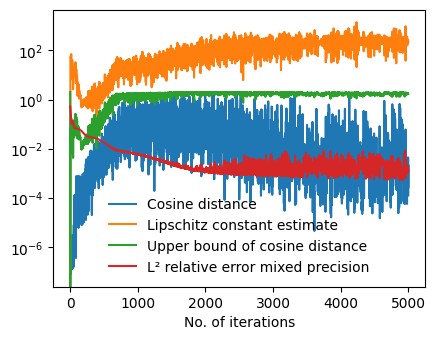

In [4]:
x = range(len(cosines))
cosines2 = [1 - r for r in cosines]
gradoverL = [g/l for g, l in zip(gradnorm, L)]
alpha = 0.00048828125
ub = [2*alpha*w/(g/(l) + alpha*w) for g, l, w in zip(gradnorm, L, wnorm)]
gradrel = [d/g for d, g in zip(graddiff, gradnorm)]
print(graddiff)
print(gradnorm)
ubr = [l*alpha*w/g for l, w, g in zip(L, wnorm, gradnorm)]
plt.clf()
plt.figure(figsize=(4.8,3.6))
plt.xlabel('No. of iterations')
plt.plot(x, cosines2, label = "Cosine distance")
plt.plot(x, L, label = "Lipschitz constant estimate")
plt.plot(x, ub, label = "Upper bound of cosine distance")
plt.plot(x, loss_mixed, label = "L² relative error mixed precision")
plt.yscale('log')
leg = plt.legend(loc='lower center', frameon = False)
plt.savefig("lipschitz.pdf", bbox_inches='tight')
plt.show()

<ipython-input-5-ad600535df5f>:4: RuntimeWarning: divide by zero encountered in double_scalars
  gradoverL = [g/l for g, l in zip(gradnorm, L)]
<ipython-input-5-ad600535df5f>:11: RuntimeWarning: divide by zero encountered in double_scalars
  thing = [g/(w*l) for g, w, l in zip(gradnorm, wnorm, L)]


<Figure size 640x480 with 0 Axes>

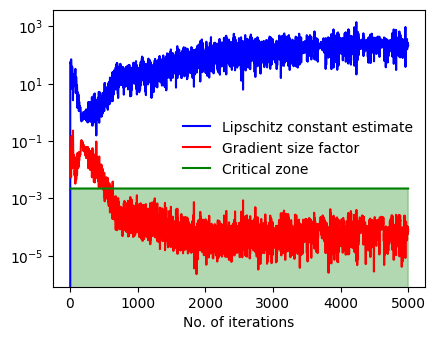

In [5]:
x = range(len(cosines))
zero = [0] * len(cosines)
cosines2 = [1 - r for r in cosines]
gradoverL = [g/l for g, l in zip(gradnorm, L)]
a = 0.00217260241
gradrel = [d/g for d, g in zip(graddiff, gradnorm)]
trueL = L[0:100]
for i in range(100, len(L)):
    trueL.append(max(trueL[-1], L[i]))
crit = [a for l in trueL]
thing = [g/(w*l) for g, w, l in zip(gradnorm, wnorm, L)]
plt.clf()
plt.figure(figsize=(4.8,3.6))
plt.xlabel('No. of iterations')
plt.plot(x, L, label = "Lipschitz constant estimate", color = 'blue')
plt.plot(x, thing, label = "Gradient size factor", color = 'red')
plt.plot(x, crit, label = "Critical zone", color = 'green')
plt.fill_between(x, crit, zero, color = 'green', alpha = 0.3)

plt.yscale('log')
leg = plt.legend(loc='right', frameon = False)
plt.savefig("bound-test.pdf", bbox_inches='tight')
plt.show()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

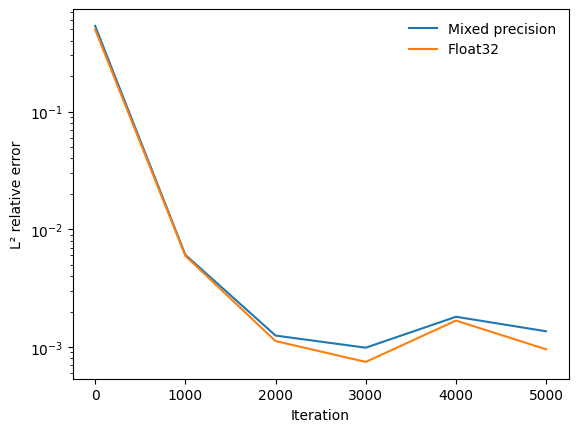

mixed precision: 
0.0008288504
float 32: 
0.000559329


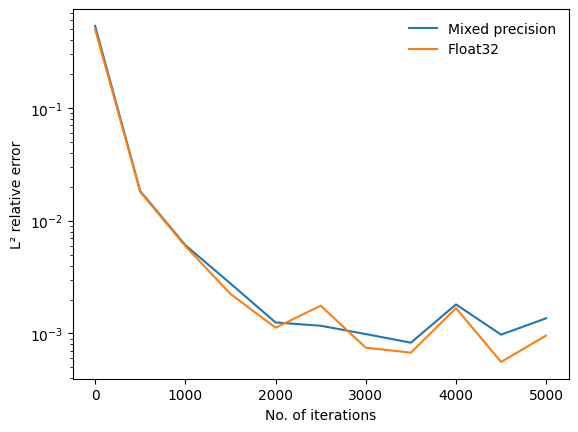

mixed precision: 
0.0007193492
float 32: 
0.000534455


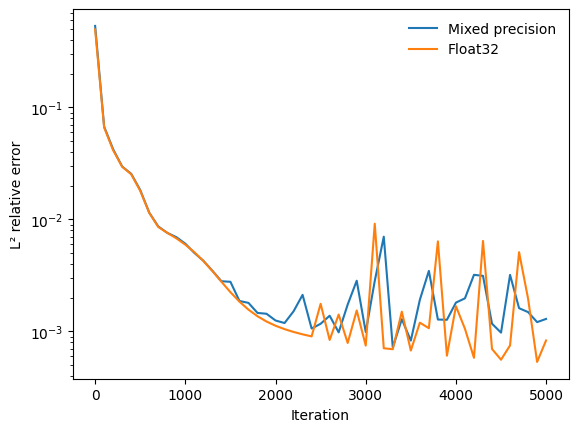

mixed precision: 
0.00053454
float 32: 
0.00053117337


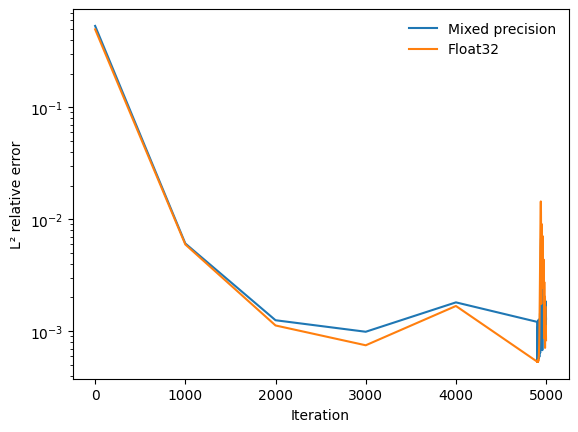

mixed precision: 
0.00053454
float 32: 
0.0005289996


<Figure size 640x480 with 0 Axes>

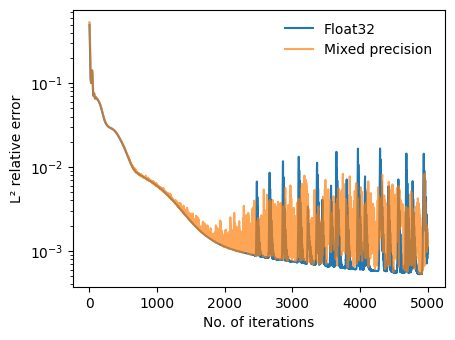

<Figure size 640x480 with 0 Axes>

In [6]:
#@title testing at different frequencies

x = [i for i in range(len(cosines))]
print(x)
plt.xlabel("Iteration")
plt.ylabel("L² relative error")
plt.plot(x[::1000] + [x[-2]], loss_mixed[::1000] + [loss_mixed[-2]], label = "Mixed precision")
plt.plot(x[::1000] + [x[-2]], loss_32[::1000] + [loss_32[-2]], label = "Float32")
plt.yscale('log')
leg = plt.legend(loc='upper right', frameon = False)
print("mixed precision: ")
print(min(loss_mixed[::1000] + [loss_mixed[-2]]))
print("float 32: ")
print(min(loss_32[::1000] + [loss_32[-2]]))
plt.show()
plt.clf()

plt.xlabel("No. of iterations")
plt.ylabel("L² relative error")
plt.plot(x[::500] + [x[-2]], loss_mixed[::500] + [loss_mixed[-2]], label = "Mixed precision")
plt.plot(x[::500] + [x[-2]], loss_32[::500] + [loss_32[-2]], label = "Float32")
plt.yscale('log')
leg = plt.legend(loc='upper right', frameon = False)
print("mixed precision: ")
print(min(loss_mixed[::500] + [loss_mixed[-2]]))
print("float 32: ")
print(min(loss_32[::500] + [loss_32[-2]]))
plt.savefig("freq-500.pdf")
plt.show()
plt.clf()

plt.xlabel("Iteration")
plt.ylabel("L² relative error")
plt.plot(x[::100] + [x[-1]], loss_mixed[::100] + [loss_mixed[-1]], label = "Mixed precision")
plt.plot(x[::100] + [x[-1]], loss_32[::100] + [loss_32[-1]], label = "Float32")
plt.yscale('log')
leg = plt.legend(loc='upper right', frameon = False)
print("mixed precision: ")
print(min(loss_mixed[::100] + [loss_mixed[-2]]))
print("float 32: ")
print(min(loss_32[::100] + [loss_32[-2]]))
plt.show()
plt.clf()

plt.xlabel("Iteration")
plt.ylabel("L² relative error")
plt.plot(x[:4900:1000] + x[4900:], loss_mixed[:4900:1000] + loss_mixed[4900:], label = "Mixed precision")
plt.plot(x[:4900:1000] + x[4900:], loss_32[:4900:1000] + loss_32[4900:], label = "Float32")
plt.yscale('log')
leg = plt.legend(loc='upper right', frameon = False)
print("mixed precision: ")
print(min(loss_mixed[:4900:1000] + loss_mixed[4900:]))
print("float 32: ")
print(min(loss_32[:4900:1000] + loss_32[4900:]))
plt.show()
plt.clf()

plt.figure(figsize=(4.8,3.6))
plt.xlabel("No. of iterations")
plt.ylabel("L² relative error")
plt.plot(x, loss_32, label = "Float32")
plt.plot(x, loss_mixed, label = "Mixed precision", alpha=0.7)
plt.yscale('log')
leg = plt.legend(loc='upper right', frameon = False)
print("mixed precision: ")
print(min(loss_mixed))
print("float 32: ")
print(min(loss_32))
plt.savefig("freq-1.pdf", bbox_inches='tight')
plt.show()
plt.clf()